### Barebones Implementation of SIFT

In [17]:
import cv2 as cv
import numpy as np
import copy
from matplotlib import pyplot as plt
from utils import Splitter
import utils
import math

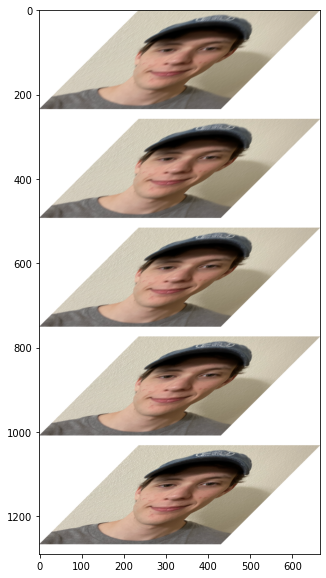

In [36]:
k = math.sqrt(2)
sigma = 1
img = cv.imread("me.PNG", cv.IMREAD_COLOR)
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
n_octaves = 4

octaves = []
for i in range(n_octaves):
    octave = utils.gen_octave(img, 5)
    img = cv.resize(img, (img.shape[0] // 2, img.shape[0] // 2))
    octaves.append(octave)

plt.figure(figsize=(10,10))
plt.imshow(utils.stack_imgs(octaves[1]))

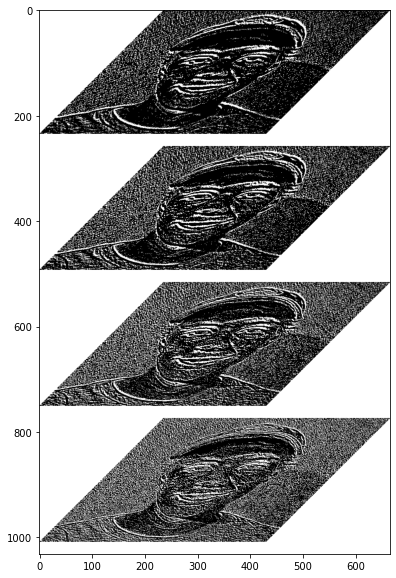

In [32]:
sample_octave = octaves[0]
for i, scale in enumerate(sample_octave):
   sample_octave[i] = cv.cvtColor(scale, cv.COLOR_BGR2GRAY)

DoGs = []
for i in range(len(sample_octave ) - 1):
    sub_img = sample_octave[i + 1] - sample_octave[i]
    DoGs.append(sub_img)

plt.figure(figsize=(10,10))
stacked = utils.stack_imgs(DoGs)
plt.imshow(stacked, cmap = "gray")

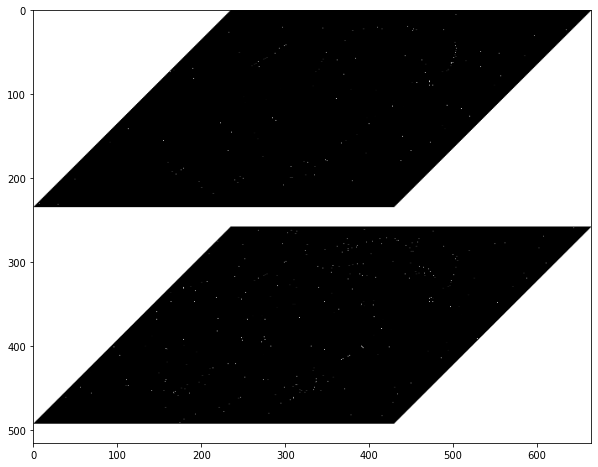

In [33]:
candidate1_map, candidates1 = utils.extrema_detection(DoGs, 1)
candidate2_map, candidates2 = utils.extrema_detection(DoGs, 2)

plt.figure(figsize=(10,10))
stacked = utils.stack_imgs([candidate1_map, candidate2_map])
plt.imshow(stacked, cmap = "gray")

number of keypoints before: 501


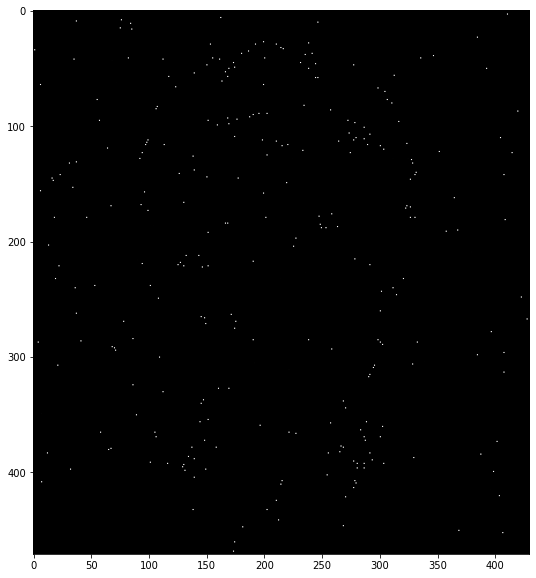

In [34]:
print(f"number of keypoints before: {len(candidates1)}")

plt.figure(figsize=(10, 10))
plt.imshow(candidate1_map, cmap="gray")

number of keypoints after refinement: 229


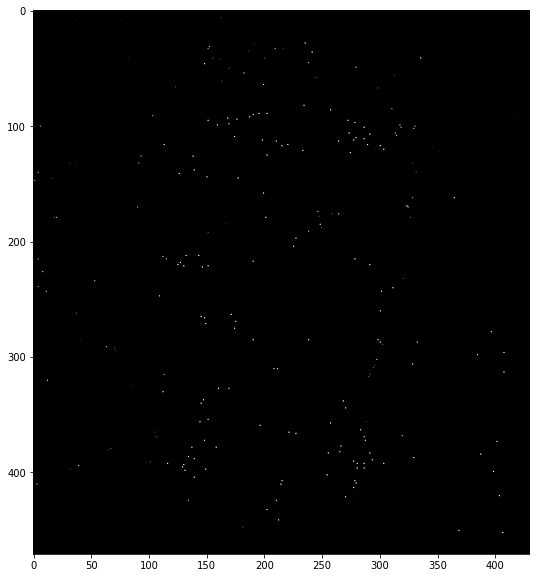

In [35]:
refined_map, refined = utils.keypoint_inter(DoGs, candidates1)
print(f"number of keypoints after refinement: {len(refined)}")

plt.figure(figsize=(10, 10))
plt.imshow(refined_map, cmap="gray")